# Data Preprocessing and Feature Selection
This notebook handles the preprocessing and feature selection for aortic aneurysm datasets. The primary goal of this notebook is to:

1. Load and preprocess multiple datasets related to aortic aneurysm research.
2. Merge datasets based on specific regions of interest (e.g., root, ascending aorta).
3. Perform feature cleaning and filtering to retain only relevant features.
4. Prepare labels for classification tasks.
5. Save the preprocessed data for further analysis.

## 1. Import Libraries and Define Global Variables

This section imports the required libraries and defines global variables, such as file paths (`FILE_PATHS`) and columns to exclude (`EXCLUDE_COLS`), which will be used throughout the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown
from typing import Dict, List
from functools import reduce
from utils import (load_data, clean_feature_df, merge_dataframes, 
                  categorize_diameter, filter_feature_types)


FILE_PATHS = {
    "Ascending": "../../Data/measures/Ascending.csv",
    "CenterlineCurvature": "../../Data/measures/AscendingProfile_CenterlineCurvature.csv",
    "Eccentricity": "../../Data/measures/AscendingProfile_Eccentricity.csv",
    "Sinuses2D": "../../Data/measures/Sinuses2D.csv",
    "Sinuses3D": "../../Data/measures/Sinuses3D.csv",
    "Features_LCS": "../../Data/radiomics/Features_LCS.csv",
    "Features_NCS": "../../Data/radiomics/Features_NCS.csv",
    "Features_RCS": "../../Data/radiomics/Features_RCS.csv",
    "Features_RootTop": "../../Data/radiomics/Features_RootTop.csv"
}

EXCLUDE_COLS = {
    "Ascending": ["max_diameter", "volume"],
    "CenterlineCurvature": [],
    "Eccentricity": [],
    "Sinuses2D": [],
    "Sinuses3D": [],
    "Features_LCS": [],
    "Features_NCS": [],
    "Features_RCS": [],
    "Features_RootTop": []
}

## 2. Define Functions

This section defines the following key functions:

1. **`merge_datasets(region_setting: str) -> pd.DataFrame`**:
   - Merges datasets based on the specified region setting (`root` or `root+aa`).
   - Cleans radiomics features and selects datasets to merge.

2. **`prepare_labels(data_dict: Dict[str, pd.DataFrame]) -> pd.DataFrame`**:
   - Prepares labels for classification tasks by categorizing the `max_diameter` column into clinical groups.

3. **`visualize_class_distribution(final_data: pd.DataFrame)`**:
   - Visualizes the class distribution of the labels using a bar chart.

In [2]:
def merge_datasets(region_setting: str) -> pd.DataFrame:
    """
    Merges datasets based on the specified region setting.
    """
    df_data = load_data(FILE_PATHS)

    # Clean radiomics features
    for key, suffix in zip(
        ["Features_LCS", "Features_NCS", "Features_RCS", "Features_RootTop"],
        ["_LCS", "_NCS", "_RCS", "_RootTop"]
    ):
        df_data[key] = clean_feature_df(df_data[key], suffix)

    # Select datasets to merge
    selected_dfs = ["Sinuses2D", "Sinuses3D", "Features_LCS", "Features_NCS", "Features_RCS", "Features_RootTop"]
    if region_setting == "root+aa":
        df_data["Ascending"] = df_data["Ascending"].drop(columns=EXCLUDE_COLS["Ascending"], errors="ignore")
        selected_dfs += ["Ascending", "CenterlineCurvature", "Eccentricity"]

    # Merge datasets
    merged = merge_dataframes(df_data, selected_dfs)
    return merged

def prepare_labels(data_dict: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Prepares labels for classification tasks.
    """
    label_data = data_dict["Ascending"][["ID", "max_diameter"]].copy()
    label_data["Label"] = label_data["max_diameter"].apply(categorize_diameter)
    return label_data

def visualize_class_distribution(final_data: pd.DataFrame):
    """
    Visualizes the class distribution of the labels.
    """
    plt.figure(figsize=(8, 4))
    final_data["Label"].value_counts().sort_index().plot(kind="bar")
    plt.title("Class Distribution")
    plt.xticks([0, 1, 2, 3], ["<40mm", "40-45mm", "45-50mm", "≥50mm"], rotation=0)
    plt.show()

## 3. Main Workflow

This section executes the main workflow of the notebook:

1. **Load Datasets**:
   - Loads datasets from the specified file paths (`FILE_PATHS`) into a dictionary (`data_dict`).

2. **Merge Datasets**:
   - Merges datasets based on the selected region setting (`root+aa`).

3. **Prepare Labels**:
   - Prepares classification labels by categorizing the `max_diameter` column.

4. **Merge Labels with Data**:
   - Combines the merged datasets with the prepared labels.

5. **Visualize Class Distribution**:
   - Visualizes the distribution of the classification labels.

Loaded datasets:
Ascending: (215, 9)
CenterlineCurvature: (215, 22)
Eccentricity: (215, 22)
Sinuses2D: (215, 27)
Sinuses3D: (215, 7)
Features_LCS: (215, 147)
Features_NCS: (215, 147)
Features_RCS: (215, 147)
Features_RootTop: (215, 147)


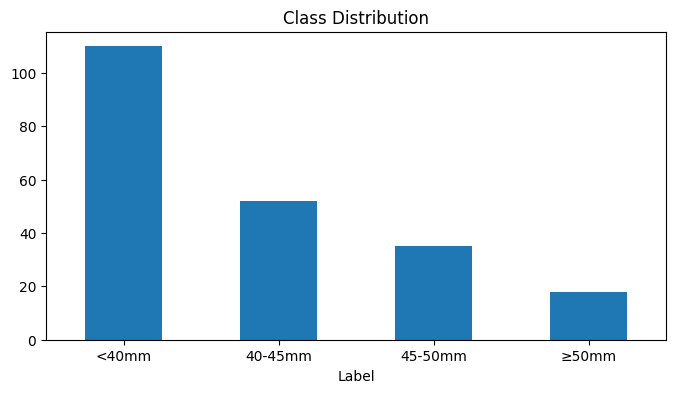

In [3]:
# Load datasets
data_dict = load_data(FILE_PATHS)
print("Loaded datasets:")
for name, df in data_dict.items():
    print(f"{name}: {df.shape}")

# Merge datasets
region_setting = "root+aa"
merged_data = merge_datasets(region_setting)

# Prepare labels
label_data = prepare_labels(data_dict)

# Merge labels with data
final_data = merged_data.merge(
    label_data[["ID", "Label", "max_diameter"]],
    on="ID",
    how="inner"
)

# Visualize class distribution
visualize_class_distribution(final_data)

## 4. Interactive Widgets

This section provides interactive widgets for exploring and saving the data:

1. **`interactive_merge(region_setting)`**:
   - Allows users to interactively merge datasets based on the selected region setting (`root` or `root+aa`).
   - Displays the first two rows of the merged dataset and its shape.

2. **`filter_features(feature_type)`**:
   - Allows users to filter features interactively based on the selected feature type (e.g., `shape+measure` or `all`).
   - Displays the distribution of feature types in a bar chart.

3. **`save_preprocessed_data_with_plot(region_setting, feature_type)`**:
   - Allows users to save the preprocessed data interactively based on the selected `region_setting` and `feature_type`.
   - Saves the filtered data to a CSV file with a descriptive name.
   - Displays a bar chart showing the class distribution of the labels in the filtered data.

In [4]:
@interact
def interactive_merge(region_setting=["root", "root+aa"]):
    merged = merge_datasets(region_setting)
    print(f"Merged shape: {merged.shape}")
    return merged

@interact
def filter_features(feature_type=["shape+measure", "all"]):
    filtered = filter_feature_types(final_data, feature_type)
    print(f"Filtered to {filtered.shape[1]} features")

    # Show feature types
    from collections import defaultdict
    feature_groups = defaultdict(int)
    for col in filtered.columns:
        if "original_shape_" in col:
            feature_groups["shape"] += 1
        elif "original_firstorder_" in col:
            feature_groups["firstorder"] += 1
        elif any(x in col for x in ["glcm", "gldm", "glrlm", "glszm", "ngtdm"]):
            feature_groups["texture"] += 1
        elif col not in ["ID", "Label", "max_diameter"]:
            feature_groups["measure"] += 1

    plt.figure(figsize=(8, 4))
    pd.Series(feature_groups).plot(kind="barh")
    plt.title("Feature Type Distribution")
    plt.show()

    return filtered

print("Save preprocessed data based on region setting and feature type")

@interact
def save_preprocessed_data_with_plot(region_setting=["root", "root+aa"], feature_type=["shape+measure", "all"]):
    # Merge datasets based on region_setting
    merged_data = merge_datasets(region_setting)
    
    # Prepare labels
    label_data = prepare_labels(data_dict)
    
    # Merge labels with data
    final_data = merged_data.merge(
        label_data[["ID", "Label", "max_diameter"]],
        on="ID",
        how="inner"
    )
    
    # Filter features based on feature_type
    filtered_data = filter_feature_types(final_data, feature_type)
    
    # Save the filtered data to a CSV file
    output_file = f"preprocessed_data_{region_setting}_{feature_type}.csv"
    filtered_data.to_csv(output_file, index=False)
    print(f"Preprocessed data saved to {output_file}")
    
    # Plot class distribution
    plt.figure(figsize=(8, 4))
    filtered_data["Label"].value_counts().sort_index().plot(kind="bar")
    plt.title(f"Class Distribution ({region_setting}, {feature_type})")
    plt.xticks([0, 1, 2, 3], ["<40mm", "40-45mm", "45-50mm", "≥50mm"], rotation=0)
    plt.xlabel("Clinical Groups")
    plt.ylabel("Count")
    plt.show()

interactive(children=(Dropdown(description='region_setting', options=('root', 'root+aa'), value='root'), Outpu…

interactive(children=(Dropdown(description='feature_type', options=('shape+measure', 'all'), value='shape+meas…

Save preprocessed data based on region setting and feature type


interactive(children=(Dropdown(description='region_setting', options=('root', 'root+aa'), value='root'), Dropd…

## 5. Next Steps: Transition to Model Training and Evaluation

With the data preprocessing and feature selection completed, the next step is to train and evaluate machine learning models using the preprocessed data. The following tasks will be performed in the next notebook, **"Model Training and Evaluation"**:

1. **Load Preprocessed Data**:
   - Import the preprocessed dataset saved in this notebook (e.g., `preprocessed_data_root_all.csv`).
   - Verify the integrity of the dataset and ensure all required columns are present.

2. **Prepare Features and Targets**:
   - Separate the feature matrix (`X`) and target variables (`y_class` for classification and `y_reg` for regression).
   - Ensure the data is ready for training by checking class distributions and feature statistics.

3. **Train and Evaluate Models**:
   - Train machine learning models for both classification (e.g., predicting clinical groups) and regression (e.g., predicting maximum diameter).
   - Use cross-validation to evaluate model performance and ensure robustness.
   - Generate performance metrics such as accuracy, confusion matrices, ROC curves (for classification), and RMSE/MAE/R² (for regression).

4. **Save Trained Models**:
   - Save the trained models (e.g., `aortic_classifier.joblib` and `aortic_regressor.joblib`) for future use in prediction or deployment.

### Prerequisites for the Next Notebook:
- Ensure the preprocessed dataset has been saved correctly (e.g., `preprocessed_data_root_all.csv`).
- Verify that all required columns (`ID`, `Label`, `max_diameter`, and features) are present in the dataset.

Proceed to the **"Model Training and Evaluation"** notebook to begin training and evaluating your models.